# 1. Data preprocessing

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [14]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder('dataset/train', transform=transform)
test_dataset = datasets.ImageFolder('dataset_demo', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
batch = next(iter(train_loader))
# clip the pixel values to be between 0 and 1
batch[0] = torch.clamp(batch[0], 0, 1)
# print 4 images (after normalization)
fig, ax = plt.subplots(1, 4, figsize=(12, 12))
for idx, image in enumerate(batch[0][:4]):
    ax[idx].imshow(image.permute(1, 2, 0))
    ax[idx].title.set_text(batch[1][idx])

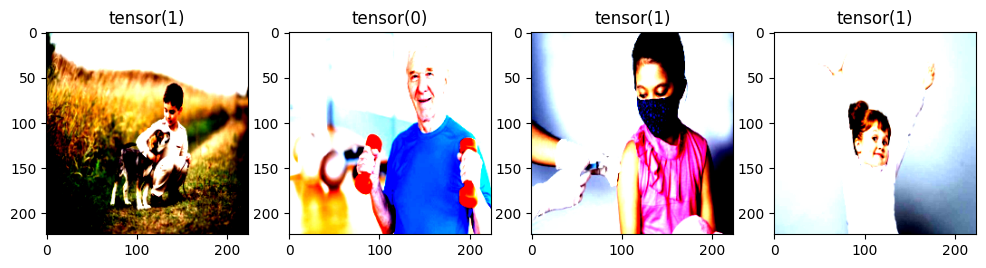

In [31]:
import numpy as np
from matplotlib import pyplot as plt
batch = next(iter(train_loader))
# clip the pixel values to be between 0 and 1
batch[0] = torch.clamp(batch[0], 0, 1)
# print images after Normalization
fig, ax = plt.subplots(1, 4, figsize=(12, 12))
for idx, image in enumerate(batch[0][:4]):
    ax[idx].imshow(image.permute(1, 2, 0))
    ax[idx].title.set_text(batch[1][idx])

# 2. Build model

In [15]:
from efficientnet_pytorch import EfficientNet

In [16]:
model_name = 'efficientnet-b0'  # You can choose from b0 to b7
model = EfficientNet.from_pretrained(model_name, num_classes=2)  # Assuming 2 classes: adults and children

Loaded pretrained weights for efficientnet-b0


# 3. Train

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [18]:
losses = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    losses.append(running_loss/len(train_loader))
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

print('Finished Training')
    

Epoch [1/5], Loss: 0.5030
Epoch [2/5], Loss: 0.1629
Epoch [3/5], Loss: 0.0605
Epoch [4/5], Loss: 0.0297
Epoch [5/5], Loss: 0.0753
Finished Training


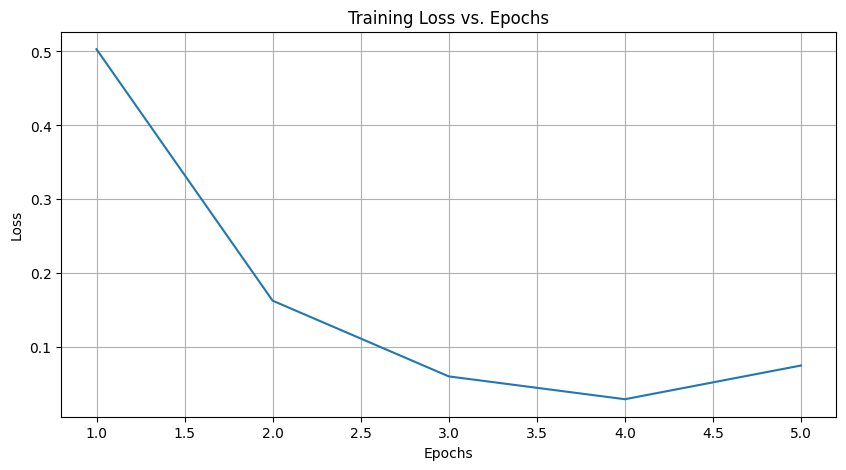

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), losses)
plt.title('Training Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# 4. Evaluation

In [20]:
model.eval()

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False
    

In [28]:
correct = 0
total = 0

In [27]:
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy on the test dataset: {accuracy:.2f}%")

Accuracy on the test dataset: 81.67%


In [29]:
from thop import profile
from thop import clever_format

input = torch.randn(1, 3, 224, 224)
flops, params = profile(model, inputs=(input, ))
flops, params = clever_format([flops, params], "%.3f")
print(f"FLOPs: {flops}, Params: {params}")


[INFO] Register zero_ops() for <class 'torch.nn.modules.padding.ZeroPad2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
FLOPs: 27.017M, Params: 44.578K


In [30]:
print(f"(1) testing accuracy of this demo dataset: {accuracy:.2f}%")
print(f"(2) FLOPs of your model: {flops}")
print(f"(3) number of trainable parameters of your model:{params}")

(1) testing accuracy of this demo dataset: 81.67%
(2) FLOPs of your model: 27.017M
(3) number of trainable parameters of your model:44.578K
